In [1]:
import numpy as np
import pyNNGP
import matplotlib.pyplot as plt
import ipywidgets as widgets

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## 2d Example
We consider a function on two inputs given by 
$$
f(x, y) = \sin(5xy) + \sin \left (5 \frac{x}{y} \right).
$$
We uniformly sample 3000 pairs of coordinates on $[0, 1]^2$, assuming that they are perturbed by $\mathcal{N} \left(0, \frac{1}{4} \right)$ noise.

In [30]:
n = 3000
m = 2
np.random.seed(5)
coords = np.random.uniform(0, 1, size=(n, 2))
s = np.argsort(coords[:,0])
coords = coords[s]
# def f(x, y):
#     return np.sin(30*x*y)+np.sin(10*x/y)-np.sin(30*x**2)
# def f(x, y, z):
#     return np.sin(5 * x * y) + np.sin(5 *y) + np.sin(5 * z)
def f(x, y):
    return np.sin(5 * x * y) + np.sin(5 * x / y)

w = f(coords[:, 0], coords[:, 1])
X = np.ones((n,1), dtype=float)
beta = np.array([0])
y = X.dot(beta) + w + np.random.normal(0, 0.25, size=n)
# y = w + np.random.normal(0, 0.25, size=n)

Let's plot the resulting surface

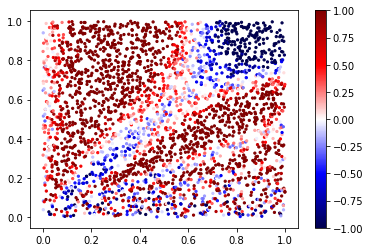

In [18]:
plt.scatter(
    coords[:,0], coords[:,1],
    c=y, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)
plt.colorbar()
plt.show()

We will train an NNGP to model this surface. We specify the model below, using the squared exponential kernel and conditioning the likelihood of each training observation on at most 3 others.

In [27]:
covModel = pyNNGP.SqExp(
    sigmaSq=0.5, 
    phi=5.0, phiUnifa=1.0, phiUnifb=50.0, phiTuning=1.0, 
    sigmaSqIGa=0.04, sigmaSqIGb=0.04
)

noiseModel = pyNNGP.ConstHomogeneousNoiseModel(0.01)

distFunc = pyNNGP.Euclidean()

nngp = pyNNGP.SeqNNGP(
    y, coords,
    nNeighbors=3,
    covModel=covModel,
    distFunc=distFunc,
    noiseModel=noiseModel
)

w_samples = []
for i in range(30):
    nngp.sample(10)
    w_samples.append(np.copy(nngp.w))

array([ 0.05949212,  0.00484362, -0.00205829,  0.00459111,  0.00261242,
       -0.01821549, -0.15333823,  0.00073887,  0.01006451, -0.00585368])

In [28]:
@interact(i=widgets.IntSlider(min=0, max=len(w_samples)-1, value=0))
def f(i):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
    i0 = axes[0].scatter(
        coords[:,0], coords[:,1], 
        c=w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i0, ax=axes[0])
    i1 = axes[1].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i], s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i1, ax=axes[1])
    i2 = axes[2].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i]-w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )
    plt.colorbar(i2, ax=axes[2])
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

Let's try that again, but this time approximate $f$ with a linear model $g$ with unknown parameters. We still assume Gaussian noise, and assume that there is an unoberved spatial process $w$ that explains the discrepancy between our model and the true process $f$. Thus, for a location/signal pair $(y, \mathbf{x})$, we perform the approximation
$$
\begin{align}
y &= f(\mathbf{x}) + \varepsilon \\
&\approx g(\mathbf{x}) + w(\mathbf{x}) + \varepsilon
\end{align}
$$
Assuming an NNGP prior on $w$, we obtain an NNGP posterior distribution on our hierarchical approximation.

In [32]:
nngp = pyNNGP.LinearNNGP(
    y, X, coords,
    nNeighbors=3,
    covModel=covModel,
    distFunc=distFunc,
    noiseModel=noiseModel
)

w_samples = []
beta_samples = []
for i in range(30):
    nngp.sample(10)
    w_samples.append(np.copy(nngp.w))
    beta_samples.append(np.copy(nngp.beta))

In [36]:
@interact(i=widgets.IntSlider(min=0, max=len(w_samples)-1, value=0))
def f(i):
    fig, axes = plt.subplots(ncols=4, figsize=(14, 3.5))
    i0 = axes[0].scatter(
        coords[:,0], coords[:,1], 
        c=w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i0, ax=axes[0])
    i1 = axes[1].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i]+X.dot(beta_samples[i]), s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i1, ax=axes[1])
    i2 = axes[2].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i]+X.dot(beta_samples[i])-w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )
    plt.colorbar(i2, ax=axes[2])
    i3 = axes[3].scatter(
        coords[:,0], coords[:,1],
        c=np.abs(w_samples[i]+X.dot(beta_samples[i])-w), s=5,
        vmin=0, vmax=1, cmap='seismic'
    )
    plt.colorbar(i3, ax=axes[3])
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

# 3D Example
We now perform a similar analysis for a 3 dimensional process. This time, we assume a three dimensional function
$$
f(x, y, z) = \sin(5xy) + \sin(5y) \sin(5z).
$$
We uniformly sample 3000 pairs of coordinates on $[0, 1]^3$, assuming that they are perturbed by $\mathcal{N} \left(0, \frac{1}{4} \right)$ noise.

In [37]:
n = 3000
m = 2
np.random.seed(5)
coords = np.random.uniform(0, 1, size=(n, 3))
s = np.argsort(coords[:,0])
coords = coords[s]
def f(x, y, z):
    return np.sin(5 * x * y) + np.sin(5 *y) + np.sin(5 * z)

w = f(coords[:, 0], coords[:, 1], coords[:, 2])
X = np.ones((n,1), dtype=float)
beta = np.array([0])
y = X.dot(beta) + w + np.random.normal(0, 0.25, size=n)
# y = w + np.random.normal(0, 0.25, size=n)

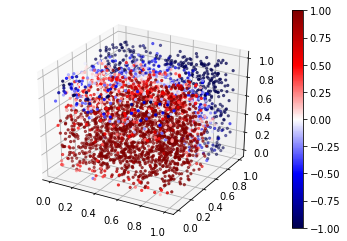

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    coords[:, 0], coords[:, 1], coords[:, 2],
    c=y, s=5,
    vmin=-1, vmax=1, cmap='seismic'
)
fig.colorbar(p)
plt.show()

In [40]:
covModel = pyNNGP.SqExp(
    sigmaSq=0.5, 
    phi=5.0, phiUnifa=1.0, phiUnifb=50.0, phiTuning=1.0, 
    sigmaSqIGa=0.04, sigmaSqIGb=0.04
)

noiseModel = pyNNGP.ConstHomogeneousNoiseModel(0.01)

distFunc = pyNNGP.Euclidean()

nngp = pyNNGP.SeqNNGP(
    y, coords,
    nNeighbors=3,
    covModel=covModel,
    distFunc=distFunc,
    noiseModel=noiseModel
)

w_samples = []
beta_samples = []
for i in range(30):
    nngp.sample(10)
    w_samples.append(np.copy(nngp.w))
#  beta_samples.append(np.copy(lnngp.beta))

In [42]:
@interact(i=widgets.IntSlider(min=0, max=len(w_samples)-1, value=0))
def f(i):
#     fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
    fig = plt.figure(figsize = (14, 3.5))
    ax0 = fig.add_subplot(131, projection='3d')
    i0 = ax0.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2], 
        c=w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i0, ax=ax0)
    ax1 = fig.add_subplot(132, projection='3d')
    i1 = ax1.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2],
        c=w_samples[i], s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i1, ax=ax1)
    ax2 = fig.add_subplot(133, projection='3d')
    i2 = ax2.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2],
        c=w_samples[i]-w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )
    plt.colorbar(i2, ax=ax2)
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

In [44]:
nngp = pyNNGP.LinearNNGP(
    y, X, coords,
    nNeighbors=3,
    covModel=covModel,
    distFunc=distFunc,
    noiseModel=noiseModel
)

w_samples = []
beta_samples = []
for i in range(30):
    nngp.sample(10)
    w_samples.append(np.copy(nngp.w))
    beta_samples.append(np.copy(nngp.beta))

In [45]:
@interact(i=widgets.IntSlider(min=0, max=len(w_samples)-1, value=0))
def f(i):
#     fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
    fig = plt.figure(figsize = (14, 3.5))
    ax0 = fig.add_subplot(131, projection='3d')
    i0 = ax0.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2], 
        c=w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i0, ax=ax0)
    ax1 = fig.add_subplot(132, projection='3d')
    i1 = ax1.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2],
        c=w_samples[i]+X.dot(beta_samples[i]), s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i1, ax=ax1)
    ax2 = fig.add_subplot(133, projection='3d')
    i2 = ax2.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2],
        c=w_samples[i]+X.dot(beta_samples[i])-w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )
    plt.colorbar(i2, ax=ax2)
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

In [ ]:
c[0]

In [ ]:
plt.plot(range(30), np.mean(c, axis=1))
plt.show()